In [10]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input

In [2]:
# Load and preprocess the data
def load_and_preprocess_data(data):
    images = []
    labels = []
    for label, image_paths in data.items():
        for path in image_paths:
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
            img = cv2.resize(img, (224, 224))  # Resize image to VGG16 input size
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
# Load data
path = pathlib.Path(r"C:\Users\akshi\OneDrive\Desktop\gmu\ait 736\mid project\kvasir-dataset\kvasir-dataset")

In [4]:
dyed_ifted_polyps = list(path.glob('dyed-lifted-polyps/*'))
dyed_resection_margins = list(path.glob('dyed-resection-margins/*'))
esophagitis = list(path.glob('esophagitis/*'))
normal_cecum = list(path.glob('normal-cecum/*'))
normal_pylorus = list(path.glob('normal-pylorus/*'))
normal_z_line = list(path.glob('normal-z-line/*'))
polyps = list(path.glob('polyps/*'))
ulcerative_colitis = list(path.glob('ulcerative-colitis/*'))

In [5]:
data = {
    'dyed-lifted-polyps' : dyed_ifted_polyps ,
    'dyed-resection-margins' : dyed_resection_margins,
    'esophagitis' : esophagitis,
    'normal-cecum' : normal_cecum,
    'normal-pylorus' : normal_pylorus,
    'normal-z-line' : normal_z_line,
    'polyps' : polyps,
    'ulcerative-colitis' : ulcerative_colitis
}

polys_labels = {
    0:'dyed-lifted-polyps',
    1:'dyed-resection-margins',
    2:'esophagitis',
    3:'normal-cecum',
    4:'normal-pylorus',
    5:'normal-z-line',
    6:'polyps',
    7:'ulcerative-colitis'
}

In [6]:
images, labels = load_and_preprocess_data(data)

In [7]:
# Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [8]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [11]:
# Load DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build your classification model on top of the pre-trained DenseNet model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
])

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data using DenseNet's preprocess_input function
train_data_densenet = densenet_preprocess_input(train_data)
val_data_densenet = densenet_preprocess_input(val_data)
test_data_densenet = densenet_preprocess_input(test_data)

In [13]:
# Train the model
history = model.fit(train_data_densenet, train_labels_encoded, epochs=10, batch_size=32, validation_data=(val_data_densenet, val_labels_encoded))

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4500 - loss: 1.6235 - val_accuracy: 0.8250 - val_loss: 0.4899
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7827 - loss: 0.5624 - val_accuracy: 0.8453 - val_loss: 0.4088
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8208 - loss: 0.4660 - val_accuracy: 0.8500 - val_loss: 0.3867
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8436 - loss: 0.3879 - val_accuracy: 0.8438 - val_loss: 0.3670
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8378 - loss: 0.3914 - val_accuracy: 0.8687 - val_loss: 0.3246
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8721 - loss: 0.3245 - val_accuracy: 0.8609 - val_loss: 0.3323
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8878 - loss: 0.2838 - val_accuracy: 0.8656 - val_loss: 0.3266
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8747 - loss: 0.3027 - val_accuracy: 0.8781 - v

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data_densenet, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9004 - loss: 0.2721
Test Accuracy: 0.8849999904632568


In [16]:
# Define model creation function
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
# Define the number of classes
num_classes = 8  # Update with the number of classes in your dataset

# Perform cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train_data_densenet, train_labels_encoded)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Create ResNet50 model
    model = create_model()
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(train_data_densenet[train_index], train_labels_encoded[train_index], epochs=10, batch_size=32, validation_data=(train_data_densenet[val_index], train_labels_encoded[val_index]), verbose=1)
    
    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(train_data_densenet[val_index], train_labels_encoded[val_index], verbose=0)
    print(f"Validation Accuracy: {val_acc}")
    cv_scores.append(val_acc)

# Calculate and print the mean cross-validation score
mean_cv_score = np.mean(cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")

Fold 1/5
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.4665 - loss: 1.5367 - val_accuracy: 0.8320 - val_loss: 0.4706
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7875 - loss: 0.5920 - val_accuracy: 0.8223 - val_loss: 0.4067
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8338 - loss: 0.4499 - val_accuracy: 0.8301 - val_loss: 0.3911
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8517 - loss: 0.4122 - val_accuracy: 0.8496 - val_loss: 0.3489
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8627 - loss: 0.3661 - val_accuracy: 0.8555 - val_loss: 0.3434
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8583 - loss: 0.3552 - val_accuracy: 0.8574 - val_loss: 0.3325
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8668 - loss: 0.3219 - val_accuracy: 0.8516 - val_loss: 0.3340
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8837 - loss: 0.2945 - val_accuracy: 0.8457

25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


<Figure size 800x800 with 0 Axes>

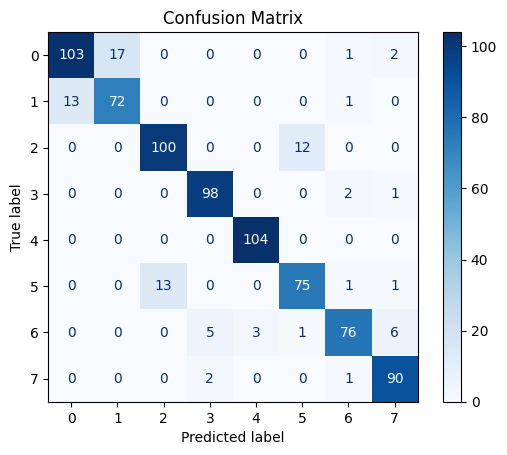

In [20]:
# Generate confusion matrix
predictions = model.predict(test_data_densenet)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels_encoded, predicted_labels)
classes = [str(i) for i in range(8)]  # Assuming you have 8 classes

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()